In [1]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append('../utils')
from pp_utils import *

In [2]:
#======================================================================================
#                        INITIALIZE DIRECTORIES
#======================================================================================
root_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw" #where the raw bdf files are
output_base = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed' #where all the preprocessed .mat files and other info go

plot = False
FS_ORIG = 2048  # Hz
#subjects_to_process = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', 
                     #  '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']  

subjects_to_process = ['01']



In [3]:
#======================================================================================
#                       PREPROCESSING PARAMETERS
#======================================================================================
# Printing general info
print_info = False

# Notch filtering
notch_applied = False
freq_notch = 50

# Bandpass filtering
bpf_applied = True
freq_low   = 0.01
freq_high  = 8
bandpass = str(freq_low) + '-' + str(freq_high)
ftype = 'butter'
order = 3

# Spherical interpolation
int_applied = False
interpolation = 'spline'

# Rereferencing using average of mastoids electrodes
reref_applied = True
reref_type = 'Mastoids'  #Mastoids #Average

# Downsampling
down_applied = True
downfreq = 128
if not down_applied:
    downfreq = FS_ORIG
downfreq_factor =int(FS_ORIG/downfreq)

In [4]:
#======================================================================================
#                       LOOP THROUGH SUBJECTS
#======================================================================================

files = sorted(glob.glob(os.path.join(root_dir, '**', '*.bdf'), recursive=True))

already_processed = []

for idx, file in enumerate(files):

    df_pre = pd.DataFrame()

    subject_ID = file.split('.')[0][-2:]
    if subject_ID not in subjects_to_process:
        continue
    elif subject_ID in already_processed: #prevents looping over same subject twice if they have multiple file fragments
        continue
    
    print("Currently processing ", file)
    already_processed.append(subject_ID)

    output_dir = os.path.join(output_base, subject_ID)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    

    

    #======================================================================================
    #                        READ EEG FILES
    #======================================================================================

    #concatenate multiple files if there are multiple files per subject
    if len(file.split('/')[-1]) > 10: 
        print("Concatenating multiple parts for same subject.")

        subject_files = sorted([file for file in files if file.split('/')[-1].split('.')[0][-2:] == "01"])
        print('Files being concatenated: ', subject_files)

        raws = [mne.io.read_raw_bdf(file, eog=None, misc=None, stim_channel='Status', 
                              infer_types=False, preload=False, verbose=None) for file in subject_files]
        
        raw = mne.concatenate_raws(raws)

    else:
        raw = mne.io.read_raw_bdf(file, eog=None, misc=None, stim_channel='Status', 
                              infer_types=False, preload=False, verbose=None)


    # Check metadata
    n_time_samps = raw.n_times
    time_secs = raw.times
    ch_names = raw.ch_names
    n_chan = len(ch_names) 

    if print_info == True:
        print('the (cropped) sample data object has {} time samples and {} channels.'
            ''.format(n_time_samps, n_chan))
        print('The last time sample is at {} seconds.'.format(time_secs[-1]))
        print('The first few channel names are {}.'.format(', '.join(ch_names[:3])))
        print('bad channels:', raw.info['bads'])  # chs marked "bad" during acquisition
        print(raw.info['sfreq'], 'Hz')            # sampling frequency
        print(raw.info['description'], '\n')      # miscellaneous acquisition info
        print(raw.info)

    if plot:
        raw.plot(start=100, duration=10)


    #======================================================================================
    #                       FIND TRIGGERS FOR SEGMENTING
    #======================================================================================
    #loading the raw events
    #the stim channel is called 'Status' 
    events = mne.find_events(raw, stim_channel='Status', shortest_event=1) #raises exception if shortest event is default 2...?
    

#...TO DO: import bad triggers noted in experiment from corresponding csv 
    bad_triggers = []
    #events.pop(bad_triggers indices)

    #cleaned triggers according to channel
    #trial start and end are indicated in channel 5, filtered for 10+ min duration
    #events_2, events_3, events_4, events_5, trial_starts = sort_events(events)
    _, _, _, _, trial_starts = sort_events(events)


   
    #======================================================================================
    #                        CROPPING FILES TO THE TRIAL
    #======================================================================================
    print("trial starts: \n", trial_starts)
    
    #trial durations
    listen_dur = 665
    motor_dur = 600
    error_dur = 600

    #start times for cropping
    listen_pre_start, motor_pre_start, error_pre_start, listen_post_start, motor_post_start, error_post_start = trial_starts[:,0]/FS_ORIG
    
    #end times
    listen_pre_end = listen_pre_start+listen_dur
    motor_pre_end = motor_pre_start+motor_dur
    error_pre_end = error_pre_start+error_dur
    listen_post_end = listen_post_start+listen_dur
    motor_post_end = motor_post_start+motor_dur
    error_post_end = error_post_start+error_dur
    


    if subject_ID == '01':
        error_pre_end = error_pre_start+430 #exception for subject 1

#.....TO DO
    #add stuff for post 
    #approximate crop for training?

    eeg_listen_pre = raw.copy().crop(tmin = listen_pre_start, tmax = listen_pre_end)
    eeg_motor_pre = raw.copy().crop(tmin = motor_pre_start, tmax = motor_pre_end)
    eeg_error_pre = raw.copy().crop(tmin = error_pre_start, tmax = error_pre_end)
    eeg_listen_post = raw.copy().crop(tmin = listen_post_start, tmax = listen_post_end)
    eeg_motor_post = raw.copy().crop(tmin = motor_post_start, tmax = motor_post_end)
    eeg_error_post = raw.copy().crop(tmin = error_post_start, tmax = error_post_end)
   

    #------------------------   
    # CHOOSING FILES TO PROCESS
    #---------------------------

    #get the eeg data
    eegs_to_process = [eeg_error_post]
    #eegs_to_process = []
    eeg_names = ['eeg_error_post']
    

    #======================================================================================
    #                       FILTERING
    #======================================================================================
    for i, data in enumerate(eegs_to_process):
        ## -------------
        ## Select channels
        ## -------------

        #eeg_channels = ch_names[:66] + [ch_names[-1]]
        eeg_channels = ch_names[0:66]
        eeg = data.copy().pick_channels(eeg_channels)
        if plot:
            eeg.plot(start=100, duration=10, n_channels=len(raw.ch_names))

        
        """eeg_channels = ch_names[0:66]
        eeg = eeg.pick_channels(eeg_channels)
        if plot:
            eeg.plot(start=100, duration=10, n_channels=len(raw.ch_names))"""
  
         #...BP filtering
         
         #...interpolation
            
        
        #... re-referencing
         
         
        ## -------------
        ## Downsampling
        ## -------------
        df_pre['down_applied'] = [down_applied]
        df_pre['downfreq'] = [downfreq]
        if down_applied:
            eeg = eeg.resample(sfreq=downfreq)
            if plot:
                eeg.plot()
  

    #======================================================================================
    #                      UPDATE TRIGGERS?
    #======================================================================================
      
        #create support vectors
        #zero array with downsampled dimensions
        events_original = np.zeros((5, data.get_data().shape[1])) #5 rows = event types, along time axis zero when there is an event and 1 everywhere else
        
      
        #get triggers
        section_triggers = mne.find_events(data, stim_channel='Status', shortest_event=1)
        events_2, events_3, events_4, events_5, section_start = sort_events(section_triggers, clean = True)

        #get trial start time
        section_start = section_start[0][0]
        
        #find indices corrected for start time
        indices_2 = (events_2[:,0]) - section_start
        indices_3 = (events_3[:,0]) - section_start
        indices_4 = (events_4[:,0]) - section_start
        indices_5 = (events_5[:,0]) - section_start   

        #populate event array with 1s where there are events
        
        events_original[0][indices_2] = 1
        events_original[1][indices_3] = 1
        events_original[2][indices_4] = 1
        events_original[3][indices_5] = 1

        #resample while preserving events
        cropped_length = eeg.get_data().shape[1]
        events_resampled = np.zeros((5, cropped_length))
        for row in range(events_resampled.shape[0]):
            events_resampled[row] = discretize(events_original[row], final_length = cropped_length, downfreq_factor = downfreq_factor)

        
        """events_resampled[1][indices_3] = 1
        events_resampled[2][indices_4] = 1
        events_resampled[3][indices_5] = 1  """
        """
        #discretize
        n_bins = len(events_resampled[0]) //downfreq_factor
        temp = events_resampled[0][:n_bins * 32].reshape(n_bins, 32)
        events_resampled[0] = np.any(arr_reshaped, axis=1).astype(int)
        """
       # triggers_tosave = triggers.get_data()
    #======================================================================================
    #                       SAVING CROPPED FILES
    #======================================================================================
        
        name = eeg_names[i]
        eeg_tosave = eeg.get_data()

        savemat(os.path.join(output_dir,   f'{name}_{subject_ID}.mat'), {'trial_data': eeg_tosave[0:64, :], 'trial_mastoids': eeg_tosave[64:66, :], 'events': events_resampled})
    

         ## -------------
        ## Save preprocessing stages
        ## -------------
    df_pre.to_csv(os.path.join(output_dir, f"preprocess_record_{subject_ID}.csv"), index=False)


Currently processing  /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_01_01.bdf
Concatenating multiple parts for same subject.
Files being concatenated:  ['/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_01_01.bdf', '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_02_01.bdf']
Extracting EDF parameters from /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_01_01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_02_01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Trigger channel has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
441450 events found
Event IDs: [ 65282  65284  65286  65288  65290  65296  65298  65535 130816 130818]
All event types present
trial starts: 
 [[ 332604   65280 

In [5]:
"""def discretize(arr, final_length, downfreq_factor = downfreq_factor):
    n_bins = int(len(arr)//downfreq_factor)

    if len(arr) % downfreq_factor != 0:
        remainder = downfreq_factor - (len(arr) % downfreq_factor)
        arr = np.append(arr, [0] * int(remainder))
        n_bins +=1

    arr_reshaped = arr.reshape(n_bins, downfreq_factor)
    discretized_arr = np.any(arr_reshaped, axis=1).astype(int)

    discretized_arr = discretized_arr[0:final_length]

    return discretized_arr"""


'def discretize(arr, final_length, downfreq_factor = downfreq_factor):\n    n_bins = int(len(arr)//downfreq_factor)\n\n    if len(arr) % downfreq_factor != 0:\n        remainder = downfreq_factor - (len(arr) % downfreq_factor)\n        arr = np.append(arr, [0] * int(remainder))\n        n_bins +=1\n\n    arr_reshaped = arr.reshape(n_bins, downfreq_factor)\n    discretized_arr = np.any(arr_reshaped, axis=1).astype(int)\n\n    discretized_arr = discretized_arr[0:final_length]\n\n    return discretized_arr'

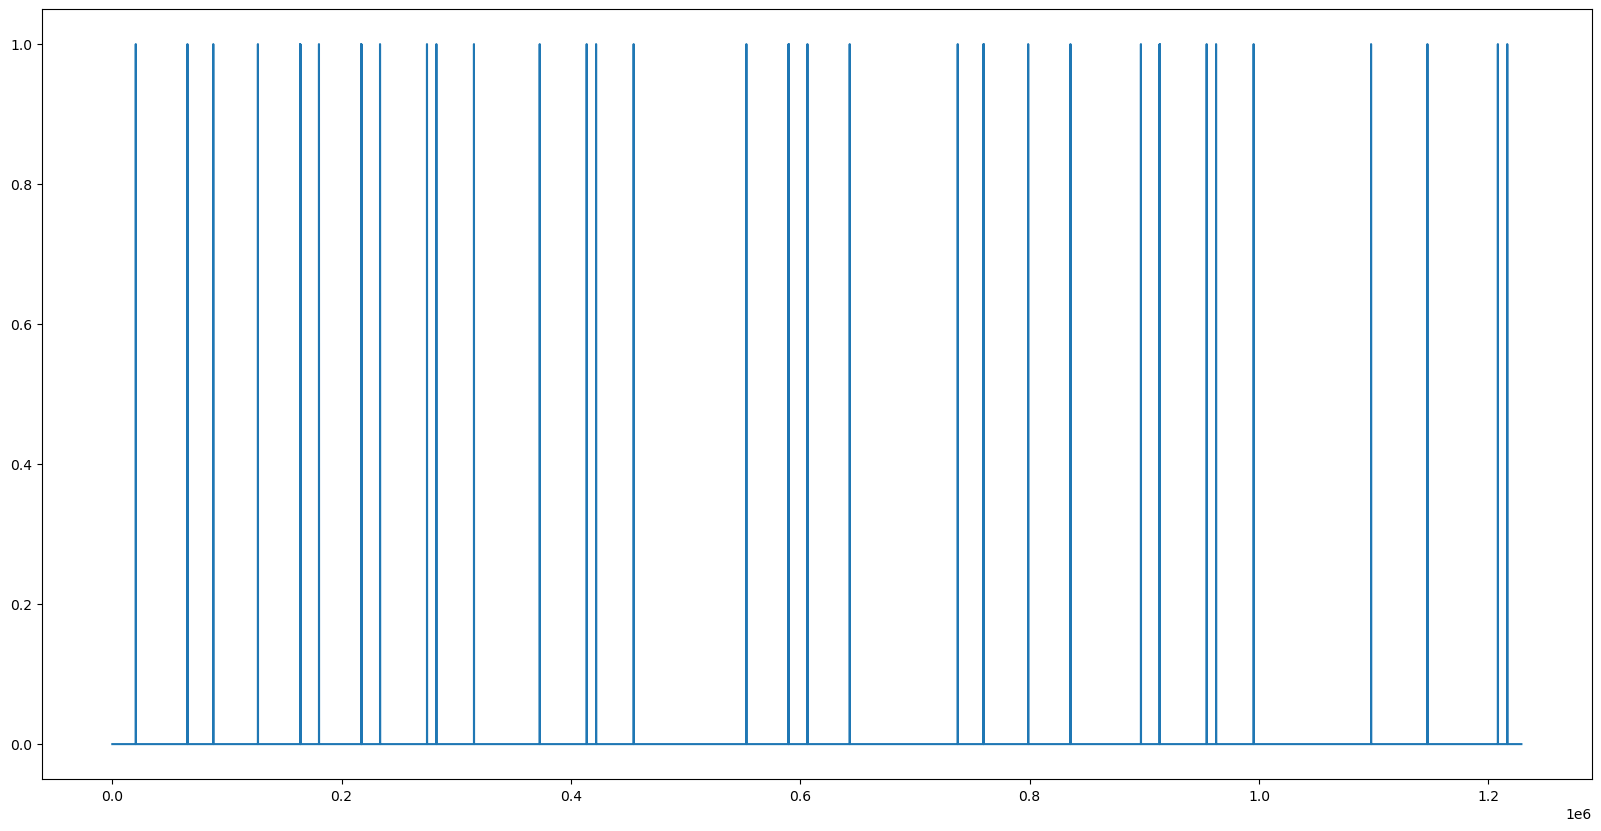

In [8]:
plt.figure(figsize=(20,10))
plt.plot(events_original[2])

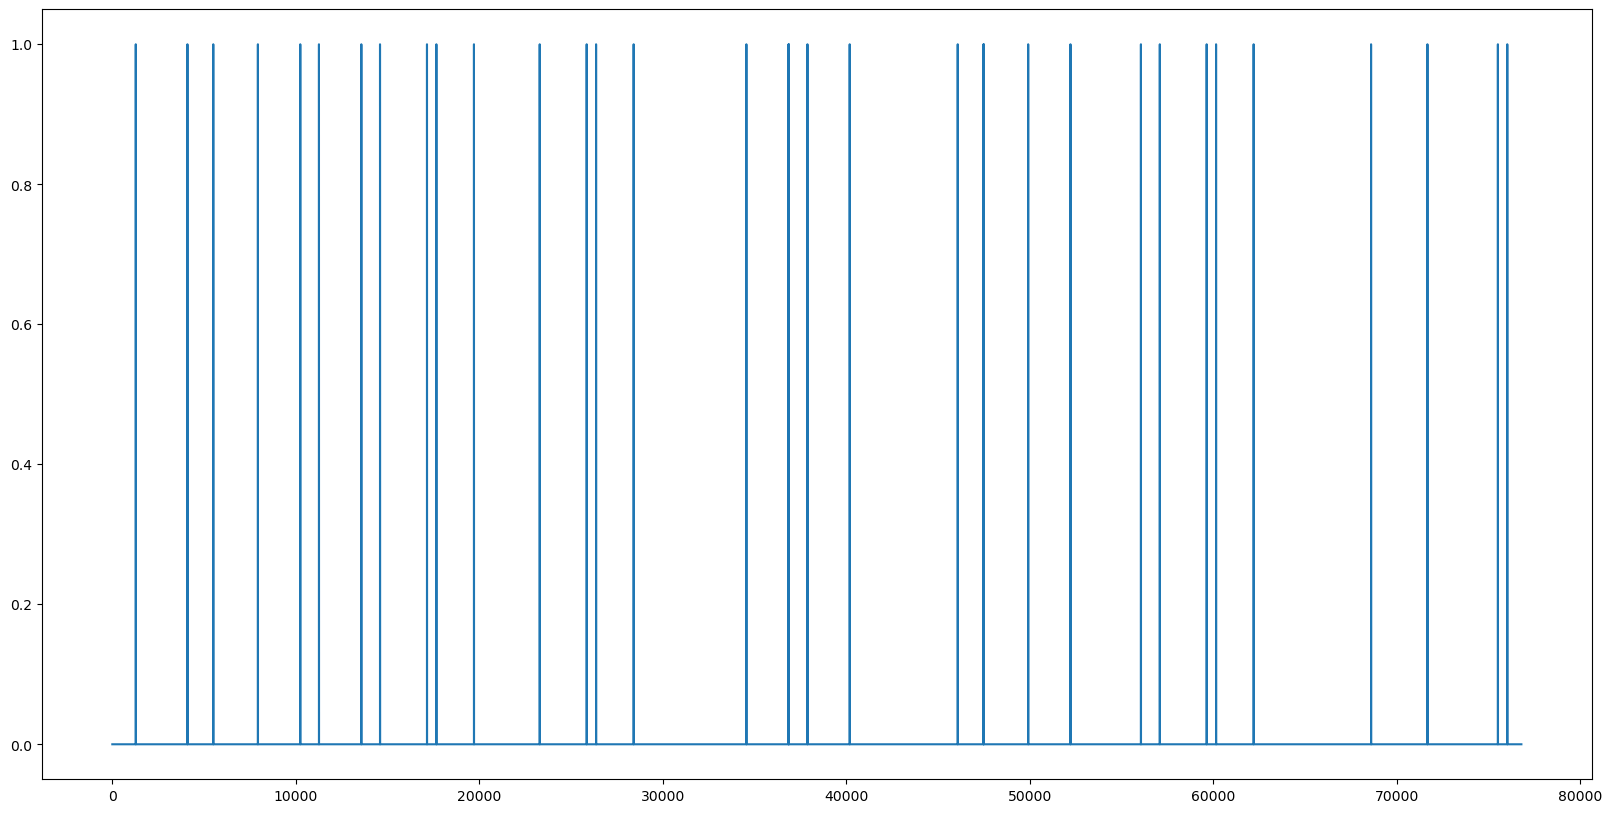

In [9]:
plt.figure(figsize=(20,10))
plt.plot(events_resampled[2])

## EXPLORATION BELOW, NOT FOR THE ACTUAL PIPELINE
Note the different thresholds used (keystroke triggers are longer than mode switch or trial triggers)

In [ ]:
trial_starts

array([[ 332604,   65280,   65296],
       [2072464,   65280,   65296],
       [3681072,   65280,   65296],
       [6102881,   65280,   65296],
       [7850577,   65280,   65296],
       [9370825,   65280,   65296]])

In [ ]:
"""raw_events = mne.find_events(raw, shortest_event=1)
raw.plot(events = raw_events)"""

'raw_events = mne.find_events(raw, shortest_event=1)\nraw.plot(events = raw_events)'

In [ ]:
listen_events_pre = clean_triggers(mne.find_events(eeg_listen_pre), threshold=1200)
eeg_listen_pre.plot(events = listen_events_pre)

Trigger channel has a non-zero initial value of 65296 (consider using initial_event=True to detect this event)
59401 events found
Event IDs: [65282 65296]
Using qt as 2D backend.
Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [ ]:
motor_events_pre = clean_triggers(mne.find_events(eeg_motor_pre), threshold=1500)
eeg_motor_pre.plot(events = motor_events_pre)

Trigger channel has a non-zero initial value of 65296 (consider using initial_event=True to detect this event)
65802 events found
Event IDs: [65282 65296]
Using qt as 2D backend.
Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [ ]:
error_events_pre = clean_triggers(mne.find_events(eeg_error_pre, shortest_event=1), threshold=1500)
eeg_error_pre.plot(events = error_events_pre)

Trigger channel has a non-zero initial value of 65296 (consider using initial_event=True to detect this event)
53780 events found
Event IDs: [65282 65284 65286 65288 65290 65296 65298]
Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [ ]:
listen_events_post =clean_triggers(mne.find_events(eeg_listen_post), threshold=1200)
eeg_listen_post.plot(events = listen_events_post)

Trigger channel has a non-zero initial value of 65296 (consider using initial_event=True to detect this event)
59326 events found
Event IDs: [65282 65296]
Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [ ]:
motor_events_post =clean_triggers(mne.find_events(eeg_motor_post, shortest_event = 1), threshold=1200)
eeg_motor_post.plot(events = motor_events_post)

Trigger channel has a non-zero initial value of 65296 (consider using initial_event=True to detect this event)
69217 events found
Event IDs: [65282 65296 65298]
Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [ ]:
error_events_post =clean_triggers(mne.find_events(eeg_error_post, shortest_event = 1), threshold=1200)
eeg_error_post.plot(events = error_events_post)

Trigger channel has a non-zero initial value of 65296 (consider using initial_event=True to detect this event)
71718 events found
Event IDs: [65282 65284 65286 65288 65290 65296 65298]
Using pyopengl with version 3.1.6


Channels marked as bad:
none
